In [143]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import xgboost as xgb
import seaborn as sns

from sklearn import ensemble
from sklearn.model_selection import train_test_split
from os.path import join
from sklearn import metrics
from omegaconf import OmegaConf

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
from src.hw2.utils import read_dfs, to_categorical, group_by_plot
from src.hw2.models import SimpleXgbRecommender
from src.hw2.configs import SIMPLE_CONFIG_PATH

## 0. Чистка данных, отбор признаков

In [101]:
file_names = ["members.csv", "sample_submission.csv", "song_extra_info.csv", "songs.csv", "test.csv", "train.csv"]

In [102]:
members_df, submissions_df, songs_extra_info_df, songs_df, test_df, train_df = read_dfs(file_names)

### `members.csv`:

In [103]:
np.unique(np.array(members_df.gender).astype(str), return_counts=True)

(array(['female', 'male', 'nan'], dtype='<U6'), array([ 7096,  7405, 19902]))

In [104]:
members_df_clean = members_df.drop(columns=["gender"]).dropna()

 - выбросим фичу с полом (80% данных отсотсвует);

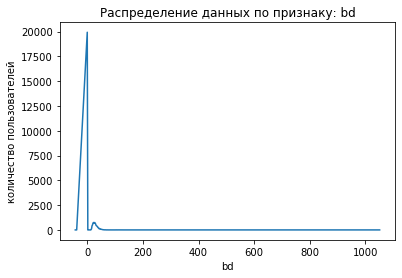

In [105]:
group_by_plot(members_df, "bd", "city", "Распределение данных по признаку: bd", "bd", "количество пользователей")

In [106]:
bd_mask = members_df_clean.bd != 0
members_df_clean.loc[bd_mask, "bd"] = 1

 - из признака bd сделаем бинарную фичу, т.к. ~60% данных (с учетом предыдущих пунктов), относятся к 1 группе;

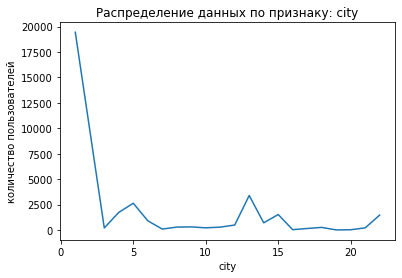

In [107]:
group_by_plot(members_df, "city", "bd", "Распределение данных по признаку: city", "city", "количество пользователей")

In [108]:
city_mask = members_df_clean.city != 1
members_df_clean.loc[city_mask, "city"] = 0

- айдишники городов сгруппируем тоже в 2 группы, на графике видно, что большая часть пользователей у нас из одного города;

In [100]:
# по фиче 'registered_via' выбросим пользователей с (устройствами?) 13 и 16, т.к. их очень мало;

# registered_via_mask1 = members_df_clean.registered_via == 13
# registered_via_mask2 = members_df_clean.registered_via == 16
# joined_mask = registered_via_mask1 & registered_via_mask2
# members_df_clean = members_df_clean[~joined_mask]

### `song_extra_info.csv`:

In [109]:
# придумать как заюзать текст песен, разбить названия песен на токены;
# взять топ 10, 100, 500 самых популярных, создать классификационную фичу. 

# songs_extra_info_df

### `song_info.csv`:

In [112]:
songs_df.isnull().sum()/songs_df.isnull().count()*100

song_id         0.000000
song_length     0.000000
genre_ids       4.098558
artist_name     0.000000
composer       46.655257
lyricist       84.712409
language        0.000044
dtype: float64

- выбросим фичу lyricist, т.к. ~85% данных по ней отсутствуют;
- остальные фичи заполним дополнительной категорией 'unknown'.

In [125]:
songs_df_clean = songs_df.drop(columns=["lyricist"]).dropna()

In [126]:
songs_df_clean = songs_df_clean.fillna(value="unknown")

In [127]:
songs_df_clean.isnull().sum()/songs_df_clean.isnull().count()*100

song_id        0.0
song_length    0.0
genre_ids      0.0
artist_name    0.0
composer       0.0
language       0.0
dtype: float64

In [128]:
# пока оставим так, может будет смысл погруппировать и пофильровать малочастноные жанры

# genre_count = songs_df_clean.groupby("genre_ids").count().song_id
# genre_id = songs_df_clean.groupby("genre_ids").count().index.tolist()
# plt.figure()
# plt.plot(genre_id, genre_count)
# plt.title('Genre data distribution')
# plt.ylabel("songs count")
# plt.show()

### `train_df`:

 - замерджим датасеты (members, songs, train);

In [129]:
train_df = train_df.merge(members_df_clean, on="msno")
train_df = train_df.merge(songs_df_clean, on="song_id")

In [130]:
train_df.isnull().sum()/train_df.isnull().count()*100

msno                      0.000000
song_id                   0.000000
source_system_tab         0.346010
source_screen_name        5.379864
source_type               0.299746
target                    0.000000
city                      0.000000
bd                        0.000000
registered_via            0.000000
registration_init_time    0.000000
expiration_date           0.000000
song_length               0.000000
genre_ids                 0.000000
artist_name               0.000000
composer                  0.000000
language                  0.000000
dtype: float64

In [131]:
train_df = train_df.fillna(value="unknown")

 - колонки с датой переведем в формат datetime и оставим только год для более высокой обобщающией способности;

In [132]:
train_df.registration_init_time = pd.to_datetime(
    train_df.registration_init_time, format='%Y%m%d', errors='ignore').dt.year
train_df.expiration_date = pd.to_datetime(train_df.expiration_date, format='%Y%m%d', errors='ignore').dt.year

  - проведем мапинг категориальных фичей;

In [133]:
train_df = to_categorical(train_df)

In [134]:
train_df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,composer,language
0,8085,41821,1,7,6,1,1,0,7,2012,2017,206471,248,1781,14421,52.0
1,25685,41821,0,11,6,0,0,1,4,2015,2017,206471,248,1781,14421,52.0
2,29366,41821,3,8,3,1,1,0,7,2012,2017,206471,248,1781,14421,52.0
3,26772,41821,3,8,3,1,0,1,9,2011,2017,206471,248,1781,14421,52.0
4,16104,41821,3,8,3,0,0,1,9,2007,2017,206471,248,1781,14421,52.0


отобразим heatmap, чтобы выделить коррелирующие друг с другом фичи;

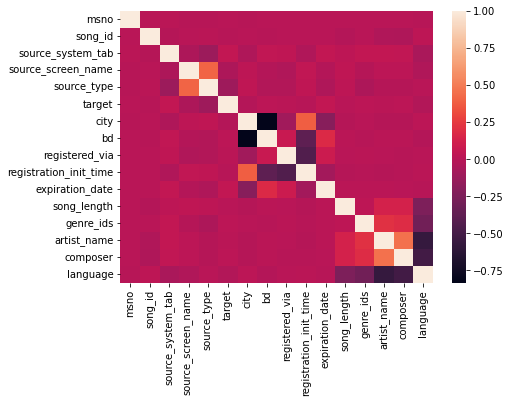

In [135]:
plt.figure(figsize=[7,5])
sns.heatmap(train_df.corr())
plt.show()

фичи с высокой корреляцией:

- source type & sorce_screen_name
- city & registration_init_time
- bd & city
- regersted_via & registration_init_time
- bd & registration_init_time
- artist_name & language
- genre_ids & language

выбросим: "bd", "source_screen_name", "registration_init_time"

In [136]:
train_df = train_df.drop(columns=["bd", "source_screen_name", "registration_init_time"])

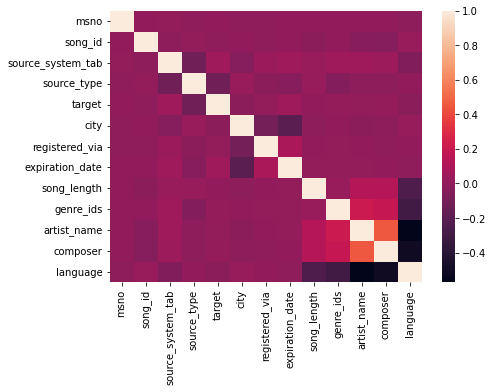

In [137]:
plt.figure(figsize=[7,5])
sns.heatmap(train_df.corr())
plt.show()

## 1. Обучение Xgboost на отобранных признках

In [75]:
config = OmegaConf.load(SIMPLE_CONFIG_PATH)
config = OmegaConf.to_container(config, resolve=True)

Обучим Xgboost для решения задачи бинарной классификации, параметры модели:

In [138]:
config

{'seed': 9,
 'k': 5,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 5,
 'n_estimators': 10,
 'eval_metric': 'auc'}

In [139]:
train_target = train_df.pop('target')

In [179]:
simple_model = SimpleXgbRecommender(**config)
aucs, feature_importances = simple_model.train(train_df, train_target)

/Users/diat.lov/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [180]:
f"Mean auc 5 folder-eval: {np.round(np.mean(aucs), 3)}"

'Mean auc 5 folder-eval: 0.656'

- посмотрим на наиболее значимые фичи и попробуем облегчить модель избавившись от неинформатиых признаков:

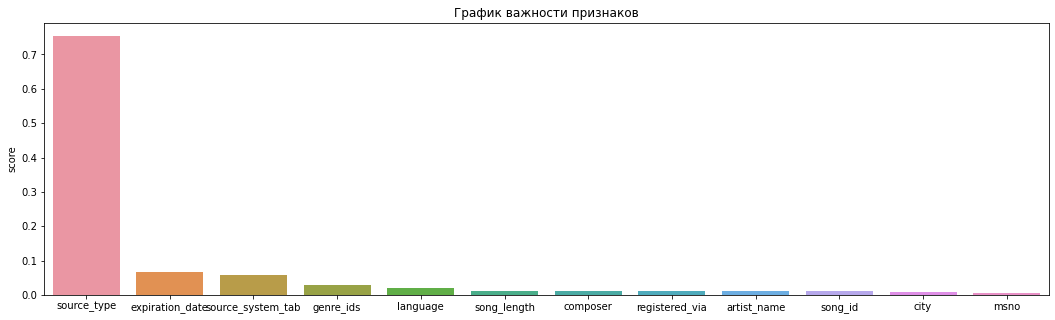

In [182]:
data = pd.DataFrame(
    data=feature_importances, index=train_df.columns, columns=["score"]).sort_values(by = "score", ascending=False)
plt.figure(figsize=[18, 5])
sns.barplot(x = data.index, y = data.score)
plt.title('График важности признаков')
plt.show()

- видно, что у дерева в принципе 1 фича по которой оно принимается решение, source_type.